## Дипломная работа. Версия “SkyLenta: Эксперимент и калькулятор”

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.stats.proportion as proportion

1. ***Импорт и анализ таблиц***
    

    1.1.   Импортируем данные в окружение *Jupyter Notebook*.
    

In [64]:
df_orders=pd.read_excel('Новый диплом датасет.xlsx',sheet_name ='Данные')
df_clients= pd.read_excel('Новый диплом датасет.xlsx',sheet_name ='Clients')
df_region_dict=pd.read_excel('Новый диплом датасет.xlsx',sheet_name ='Region_dict')

In [65]:
df_orders.head(5)

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221000
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992000
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744000
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437000
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468000


In [66]:
df_clients.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
1,193942,NaT,0,13
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015


In [67]:
df_region_dict.head(5)

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир


    
    1.2.   Изучаем все три таблицы и проверяем их на наличие пустых значений.
    

In [68]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37989 entries, 0 to 37988
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_order     37989 non-null  int64  
 1   id_client    37401 non-null  float64
 2   amt_payment  35845 non-null  float64
 3   dtime_pay    35828 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ MB


In [69]:
non_amt_payment = len(df_orders[df_orders['amt_payment'].isnull()]['amt_payment'])
non_dtime_pay = len(df_orders[df_orders['dtime_pay'].isnull()]['dtime_pay'])
non_id_client = len(df_orders[df_orders['id_client'].isnull()]['id_client'])

print('пустые поля по оплатам у', non_amt_payment ,'записей')
print('пустые поля времени платежа у', non_dtime_pay ,'записей')
print('пустые поля id_client у', non_id_client ,'записей')

пустые поля по оплатам у 2144 записей
пустые поля времени платежа у 2161 записей
пустые поля id_client у 588 записей


In [70]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.7 MB


In [71]:
non_dtime_ad = len(df_clients[df_clients['dtime_ad'].isnull()])

print('пустые поля времени показа рекламы у', non_dtime_ad ,'записей')

пустые поля времени показа рекламы у 249 записей


In [72]:
df_region_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_trading_point  66 non-null     int64 
 1   city              66 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


    1.3.   Исключаем из таблиц все строки, в которых есть нулловые значения.

In [73]:
df_orders=df_orders[~df_orders['id_client'].isnull()]
df_orders=df_orders[~df_orders['amt_payment'].isnull()]
df_orders=df_orders[~df_orders['dtime_pay'].isnull()]
df_clients=df_clients[~df_clients['dtime_ad'].isnull()]

    
    1.4. Исследуем количество торговых точек в каждом городе - построим группировку по количеству в каждом городе.
         Визуализируем с помощью гистограммы.

In [74]:
df_cities = df_clients.merge(df_region_dict, on ='id_trading_point')
df_cities.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,city
0,180844,2022-06-08 18:38:41.414,0,212,Красноярск
1,223863,2022-08-20 21:56:54.325,0,212,Красноярск
2,201715,2022-07-30 19:07:49.264,1,212,Красноярск
3,292010,2022-07-26 20:37:16.885,1,212,Красноярск
4,190438,2022-07-02 12:53:04.753,1,212,Красноярск


In [75]:
df_cities_gr = df_cities.groupby(['city']).agg({'id_trading_point':'nunique','id_client':'count'}).reset_index()
df_cities_gr = df_cities_gr.sort_values(by=['id_trading_point','id_client'], ascending = False).reset_index()
df_cities_gr.head(5)

,index,city,id_trading_point,id_client
0,7,Москва,11,12358
1,15,Санкт-Петербург,11,8879
2,10,Новосибирск,6,5188
3,4,Казань,6,5077
4,6,Красноярск,5,5937


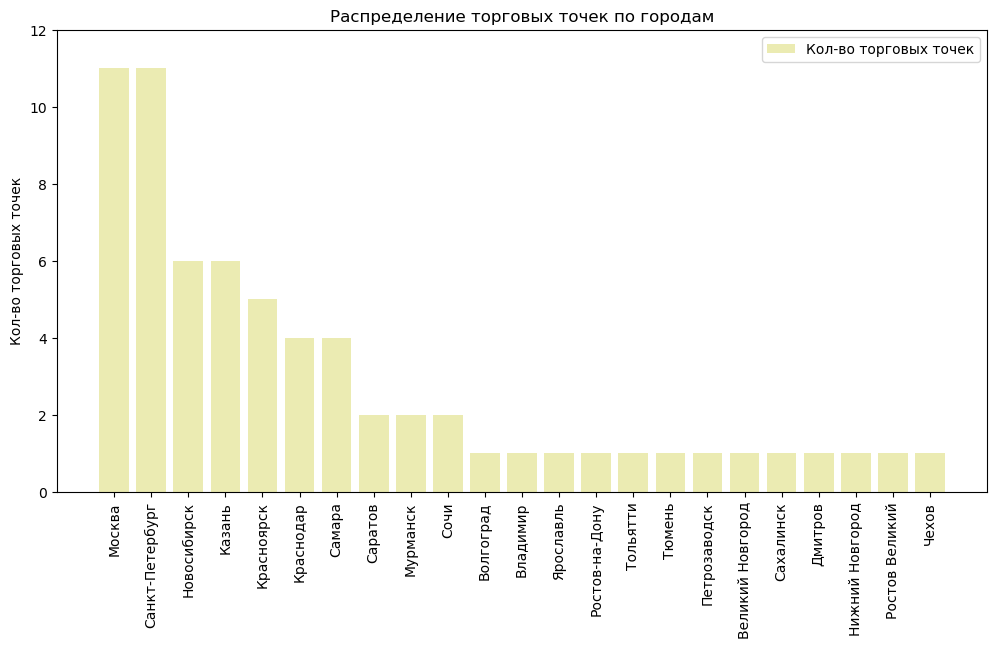

In [93]:
fig, (ax) = plt.subplots(figsize=(12, 6))

ax.bar(df_cities_gr['city'], df_cities_gr['id_trading_point'], color='y', alpha =0.3, label= 'Кол-во торговых точек' )

ax.set_ylim(0, (df_cities_gr['id_trading_point'].max()+1) )
plt.legend(loc = 'upper right')
plt.ylabel('Кол-во торговых точек')
ax.set_title('Распределение торговых точек по городам')
ax.xaxis.set_tick_params(rotation =90)

plt.show()

2
. ***Объединим таблицы***

    2.1.   У одного клиента может быть несколько платежей. Построим агрегацию таблицы с платежами, где вычислим сумму платежей на каждого клиента.
    

In [77]:
df_orders_by_clients = df_orders.groupby(['id_client']).agg({'id_order':'count','amt_payment':'sum'}).reset_index()
df_orders_by_clients.head(5)

,id_client,id_order,amt_payment
0,178561.0,1,3052.0
1,178562.0,1,2439.0
2,178563.0,1,768.0
3,178565.0,1,958.0
4,178566.0,1,5474.0


    2.2.   Соединим (по клиенту) сгруппированную таблицу с платежами с клиентской таблицей. Убедимся, что в таблице остались все клиенты из клиентской таблицы. 
    

In [78]:
print(len(df_clients))
print(df_clients.nunique()['id_client'])

55356
55356


In [79]:
df_check=df_clients.merge(df_orders_by_clients, how ='left', on = 'id_client')
df_check.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0
1,226069,2022-07-11 16:28:38.511,1,54,NaN,NaN
2,183981,2022-06-16 12:23:59.289,1,991,2.0,6322.0
3,322530,2022-07-08 08:56:08.714,0,1015,NaN,NaN
4,254313,2022-06-19 22:18:01.770,1,453,NaN,NaN


In [80]:
print(len(df_check))
print(df_check.nunique()['id_client'])

55356
55356


    2.3. Заполним нулями суммы покупок тех клиентов, которые их не совершали
    

In [81]:
df_check.fillna(0, inplace=True)
df_check.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0
1,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0
2,183981,2022-06-16 12:23:59.289,1,991,2.0,6322.0
3,322530,2022-07-08 08:56:08.714,0,1015,0.0,0.0
4,254313,2022-06-19 22:18:01.770,1,453,0.0,0.0


    2.4. С помощью словаря регионов подтянем к каждой торговой точке город, в котором она находится.

In [82]:
df_check = df_check.merge(df_region_dict, on ='id_trading_point')
df_check.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,city
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0,Красноярск
1,223863,2022-08-20 21:56:54.325,0,212,0.0,0.0,Красноярск
2,201715,2022-07-30 19:07:49.264,1,212,1.0,4171.0,Красноярск
3,292010,2022-07-26 20:37:16.885,1,212,0.0,0.0,Красноярск
4,190438,2022-07-02 12:53:04.753,1,212,1.0,6026.0,Красноярск


    2.5. Создадим поле флаг платежа, который принимает значения 0 или 1 в зависимости от того, заплатил клиент или нет.

In [83]:
df_check['flag_payment']=np.where(df_check['amt_payment']>0,1,0)
df_check.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,city,flag_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0,Красноярск,1
1,223863,2022-08-20 21:56:54.325,0,212,0.0,0.0,Красноярск,0
2,201715,2022-07-30 19:07:49.264,1,212,1.0,4171.0,Красноярск,1
3,292010,2022-07-26 20:37:16.885,1,212,0.0,0.0,Красноярск,0
4,190438,2022-07-02 12:53:04.753,1,212,1.0,6026.0,Красноярск,1


3. ***Автоматизация статистических вычислений***
    

    3.1. Создаем функцию ***test_calc***, которая будет вычислять значение t-критерия (критерия Стьюдента) и *p_value* для сравнения средних и с помощью функции *print* выводить сообщение о том, существует ли разница между средними (на основании *p_value*).    

In [84]:
def test_calc(r1, r2, alpha = 0.05):
    
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
        print("Гипотеза H0 не подтверждается: Статистическая разница подтверждена")
        print("Разница средних = ", r1.mean()-r2.mean())
    else:
        print("Гипотеза H0 подтверждается: Средние статистически равны")
        print("Разница средних = 0")
        
    return s, p

    3.2. Создаем функцию ***mann_whitney_func***, которая будет рассчитывать значение критерия Манна Уитни и p_value для сравнения распределений и с помощью функции *print* выводить сообщение о том, существует ли разница между средними (на основании *p_value*).

In [85]:
def mann_whitney_func(r1, r2, alpha=0.05):
    
    s, p = mannwhitneyu(r1, r2)
    
    if p<alpha:
        print('Распределения не равны')
    else:
        print('Распределения равны')
        
    return s, p

4. ***Чистим неверно заполненные точки***    

    4.1.  Создаем пустой список. Запустим цикл по всем торговым точкам и добавим к этому списку все торговые точки, в которых не было заплачено ни одного рубля ни одним клиентом.    

In [87]:
columns={'id_trading_point':[], 'payments_test':[], 'payments_control':[], 'clients_test':[], 'clients_control':[]}
defected_tp =pd.DataFrame(columns)

for i in df_check['id_trading_point'].unique():
    df_point = df_check[df_check['id_trading_point']== i] 
    
    df_point_test_sum = df_point[df_point['nflag_test']==1]['amt_payment'].sum()
    df_point_cntrl_sum = df_point[df_point['nflag_test']==0]['amt_payment'].sum()
        
    df_point_test_clients = df_point[df_point['nflag_test']==1]['id_client'].count()
    df_point_cntrl_clients = df_point[df_point['nflag_test']==0]['id_client'].count()
    
    #  4.2. Создаем еще один пустой список. Запускаем цикл по всем торговым точкам и добавляем к этому списку 
    #       все торговые точки, в которых пустует или контрольная, или тестовая группа.
    
    if  ((df_point_test_sum == 0 )| (df_point_cntrl_sum == 0)) | ((df_point_test_clients == 0) | (df_point_cntrl_clients == 0)):
        point_to_add = {'id_trading_point':[i],'payments_test':[df_point_test_sum],\
                        'payments_control':[df_point_cntrl_sum],'clients_test':[df_point_test_clients],\
                        'clients_control':[df_point_cntrl_clients]}
        defected_point = pd.DataFrame(point_to_add)
        defected_tp = pd.concat([defected_tp,defected_point],ignore_index=True)

defected_tp_final = defected_tp.merge(df_region_dict, on ='id_trading_point')

deleted_tp = len(defected_tp_final)
total_tp=len(df_check['id_trading_point'].unique())

print(f'Из {total_tp} торговых точек удалено {deleted_tp} по причине отсутствия продаж')
defected_tp_final

Из 66 торговых точек удалено 15 по причине отсутствия продаж


,id_trading_point,payments_test,payments_control,clients_test,clients_control,city
0,1015.0,0.0,2681186.0,0.0,1183.0,Краснодар
1,866.0,0.0,3407322.0,0.0,1337.0,Новосибирск
2,1099.0,0.0,3610847.0,0.0,1401.0,Краснодар
3,739.0,2238438.0,0.0,525.0,0.0,Новосибирск
4,46.0,0.0,1247918.0,557.0,529.0,Ярославль
5,228.0,1842578.0,0.0,870.0,0.0,Новосибирск
6,26.0,0.0,0.0,239.0,195.0,Ростов-на-Дону
7,603.0,1506495.0,0.0,647.0,0.0,Новосибирск
8,810.0,0.0,1613881.0,0.0,678.0,Новосибирск
9,800.0,0.0,2702260.0,0.0,1131.0,Новосибирск


5. ***Расcчитываем общие результаты А/Б-теста***    

    5.1. Отбрасываем все торговые точки, которые были обнаружены в **пункте 4**.

In [89]:
list_deleted_tp = defected_tp_final['id_trading_point']
df_fin = df_check[~df_check['id_trading_point'].isin(list_deleted_tp)]
df_fin.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,city,flag_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0,Красноярск,1
1,223863,2022-08-20 21:56:54.325,0,212,0.0,0.0,Красноярск,0
2,201715,2022-07-30 19:07:49.264,1,212,1.0,4171.0,Красноярск,1
3,292010,2022-07-26 20:37:16.885,1,212,0.0,0.0,Красноярск,0
4,190438,2022-07-02 12:53:04.753,1,212,1.0,6026.0,Красноярск,1


    5.2. Изобразим гистограмму платежей, на которой различными цветами изображены группы “тест” и “контроль”. 

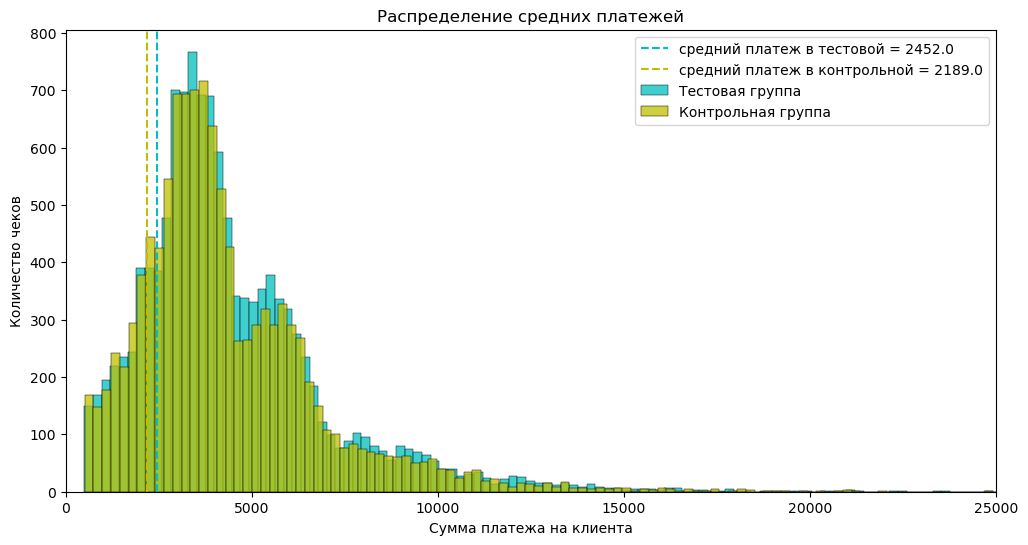

In [96]:
df_test = df_fin[df_fin['nflag_test']==1]
df_control = df_fin[df_fin['nflag_test']==0]

fig = plt.figure(figsize=(12,6))
ax1 = sns.histplot(df_test[df_test['amt_payment']>0]['amt_payment'], color='c', label='Тестовая группа')
bx2 = sns.histplot(df_control[df_control['amt_payment']>0]['amt_payment'], color='y', label ='Контрольная группа')

mean_test = round(df_test['amt_payment'].mean(),0)
mean_control = round(df_control['amt_payment'].mean(),0)

plt.title('Распределение средних платежей')
plt.ylabel('Количество чеков')
plt.xlabel('Сумма платежа на клиента')

plt.axvline(mean_test, color = 'c', linestyle='--', label=f'средний платеж в тестовой = {mean_test}')
plt.axvline(mean_control, color = 'y', linestyle='--', label = f'средний платеж в контрольной = {mean_control}')
plt.legend(loc = 'upper right')

ax1.set_xlim([0,25000])

plt.show()

    5.3. Применяем функцию ***test_calc*** и сравниваем средние платежи

In [97]:
test_calc(df_test['amt_payment'], df_control['amt_payment'])

Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  263.088912844727


(9.456798235171377, 3.3214645838934018e-21)

    5.4. Применяем функцию test_calc и сравниваем конверсию в платеж

In [98]:
test_calc(df_test['flag_payment'], df_control['flag_payment'])

Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.043524040271688325


(9.282032730948323, 1.7338073027564523e-20)

    5.5. Применяем функцию ***mann_whitney_func***

In [99]:
mann_whitney_func(df_test['amt_payment'], df_control['amt_payment'])

Распределения не равны


(270040116.0, 3.008345273971901e-24)

 6. ***Сегментация результатов АБ Теста***

In [102]:
def histplot(df, city, point):
    df_c_test = df[df['nflag_test']==1]
    df_c_control = df[df['nflag_test']==0]

    fig = plt.figure(figsize=(7,4))
    ax1 = sns.histplot(df_c_test[df_c_test['amt_payment']>0]['amt_payment'], color='c', label='Тестовая группа')
    bx2 = sns.histplot(df_c_control[df_c_control['amt_payment']>0]['amt_payment'], color='y', label ='Контрольная группа')

    mean_test_c = round(df_c_test['amt_payment'].mean(),0)
    mean_control_c = round(df_c_control['amt_payment'].mean(),0)

    plt.title(f'Распределение средних платежей в г.{city} ТТ= {point}')
    plt.ylabel('Количество чеков')
    plt.xlabel('Сумма платежа на клиента')

    plt.axvline(mean_test_c, color = 'c', linestyle='--', label=f'средний платеж в тестовой = {mean_test_c}')
    plt.axvline(mean_control_c, color = 'y', linestyle='--', label = f'средний платеж в контрольной = {mean_control_c}')
    plt.legend(loc = 'upper right')

    ax1.set_xlim([0,25000])

    plt.show()
    
    print(f'ВЫВОДЫ по г.{city} в ТТ {point} :')
    print()
    print('Результат сравнения распределения платежей в тестовой и контрольной группах')
    mann_whitney_func(df_c_test['amt_payment'], df_c_control['amt_payment'])
    print()
    
    print('Анализ разницы в размере платежа на клиента')
    test_calc(df_c_test['amt_payment'], df_c_control['amt_payment'])
    print()
    
    print('Анализ разницы в конверсии')
    test_calc(df_c_test['flag_payment'], df_c_control['flag_payment'])
    print()
    
    print('Анализ разницы в количестве заказов на клиента')
    test_calc(df_c_test['id_order'], df_c_control['id_order'])
    print()

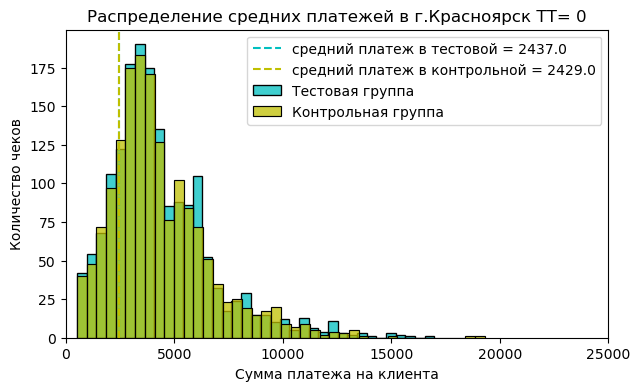

ВЫВОДЫ по г.Красноярск в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



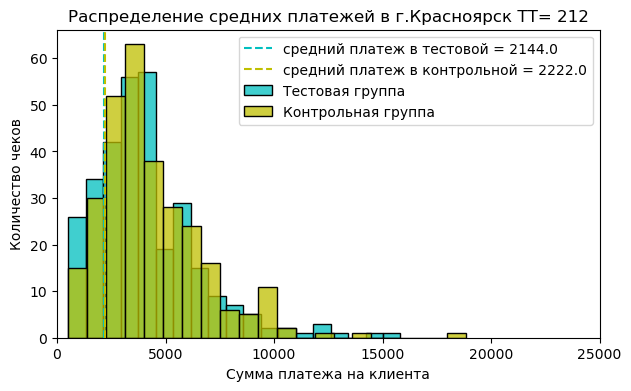

ВЫВОДЫ по г.Красноярск в ТТ 212 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



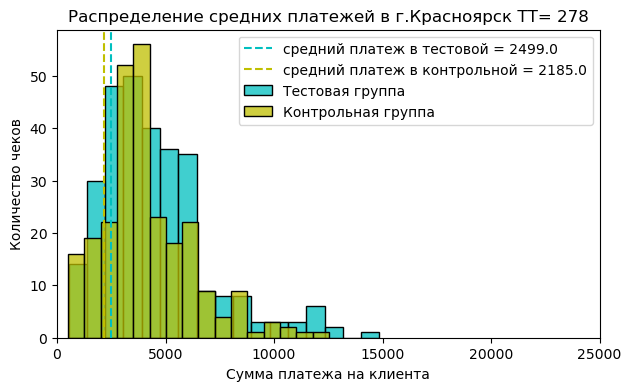

ВЫВОДЫ по г.Красноярск в ТТ 278 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



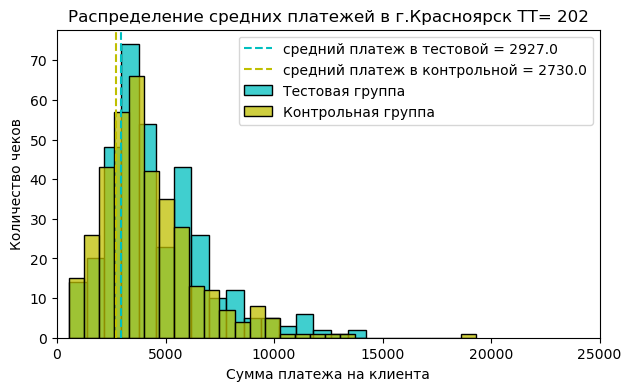

ВЫВОДЫ по г.Красноярск в ТТ 202 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



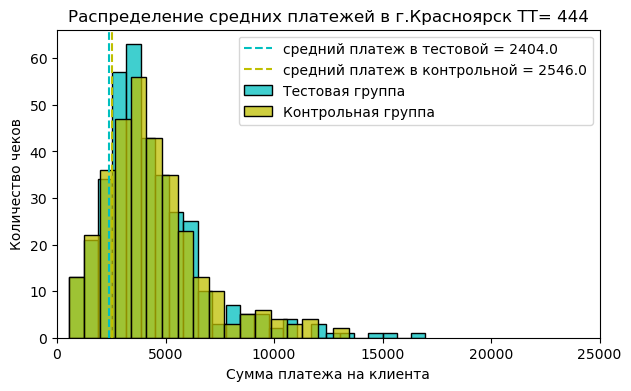

ВЫВОДЫ по г.Красноярск в ТТ 444 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



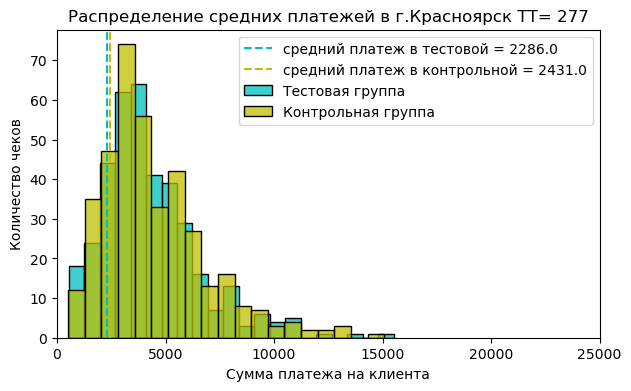

ВЫВОДЫ по г.Красноярск в ТТ 277 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



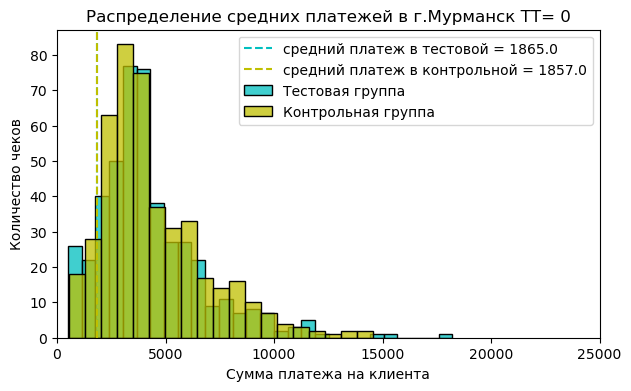

ВЫВОДЫ по г.Мурманск в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



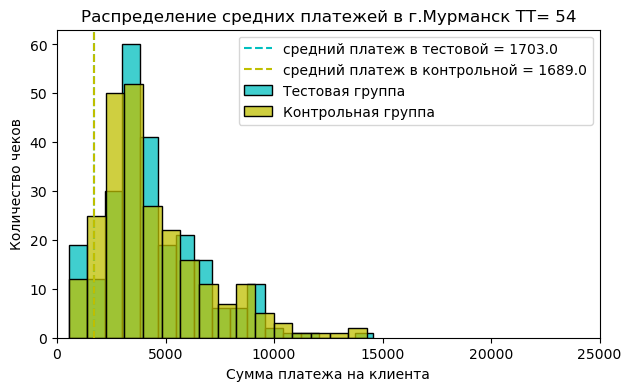

ВЫВОДЫ по г.Мурманск в ТТ 54 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



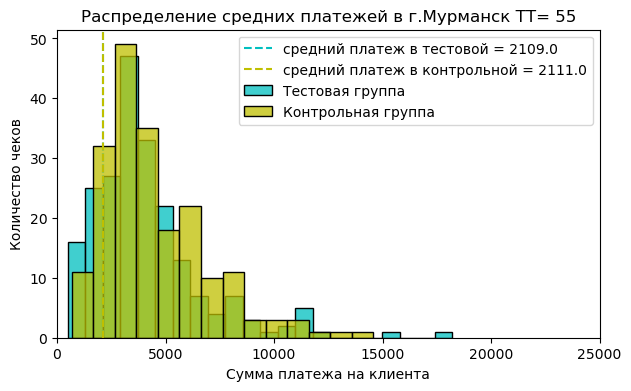

ВЫВОДЫ по г.Мурманск в ТТ 55 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



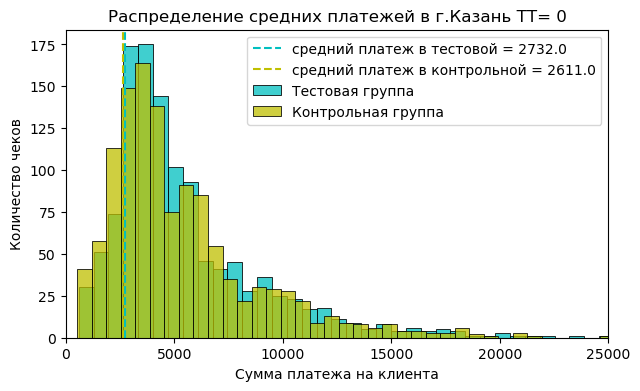

ВЫВОДЫ по г.Казань в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



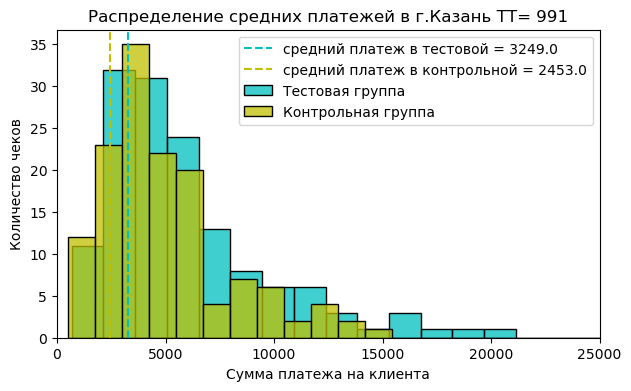

ВЫВОДЫ по г.Казань в ТТ 991 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  796.2950869236583

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



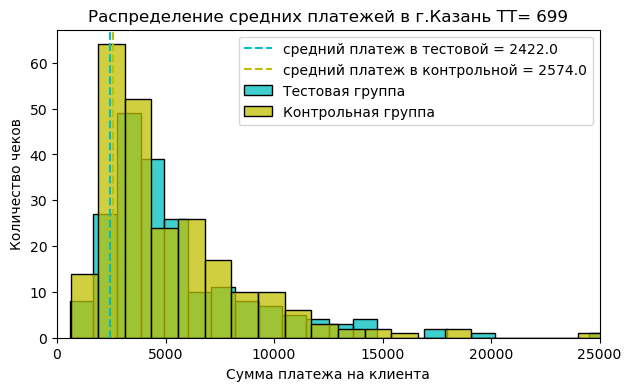

ВЫВОДЫ по г.Казань в ТТ 699 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



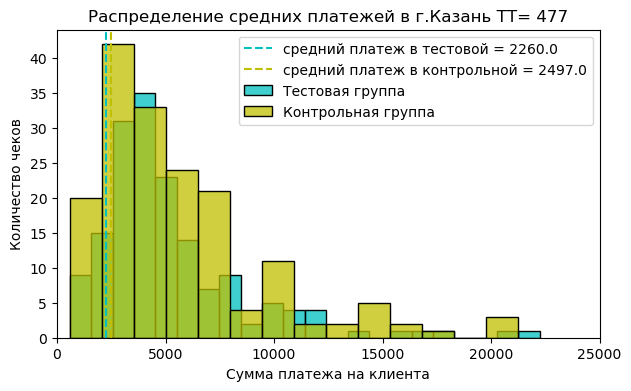

ВЫВОДЫ по г.Казань в ТТ 477 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



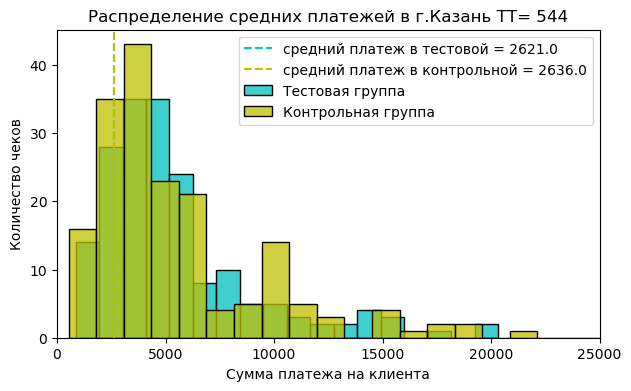

ВЫВОДЫ по г.Казань в ТТ 544 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



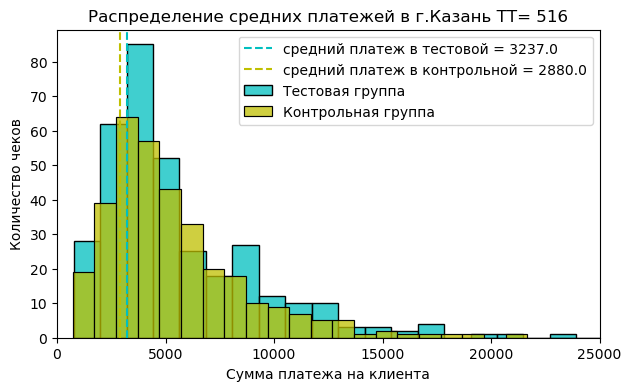

ВЫВОДЫ по г.Казань в ТТ 516 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



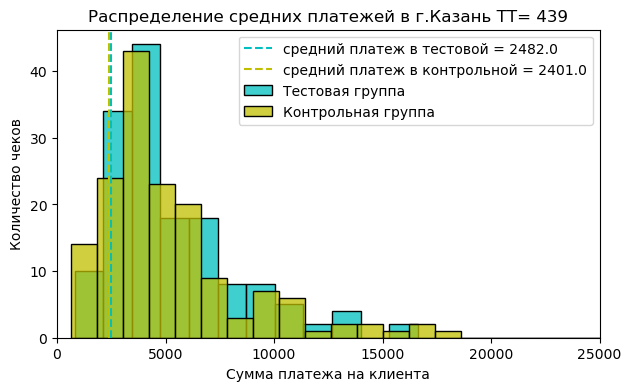

ВЫВОДЫ по г.Казань в ТТ 439 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



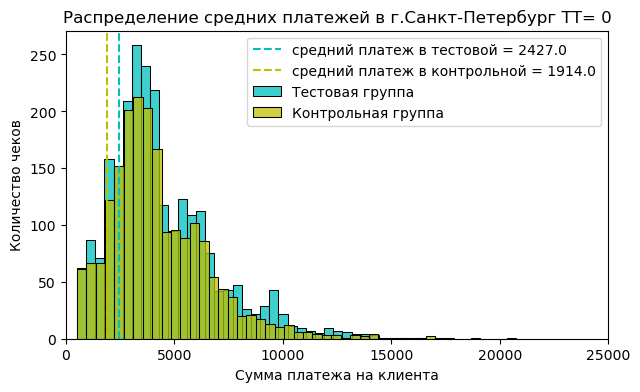

ВЫВОДЫ по г.Санкт-Петербург в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  513.9039043833998

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.09877797751600403

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.15816055807638385



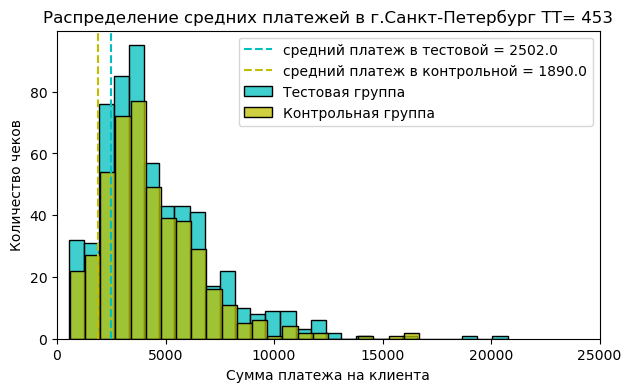

ВЫВОДЫ по г.Санкт-Петербург в ТТ 453 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  612.0424920007797

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.11967888653001074

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1913749716070161



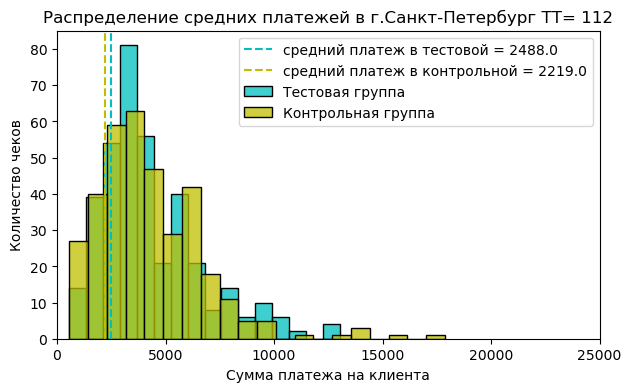

ВЫВОДЫ по г.Санкт-Петербург в ТТ 112 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.05984963486602768

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.09769691634704347



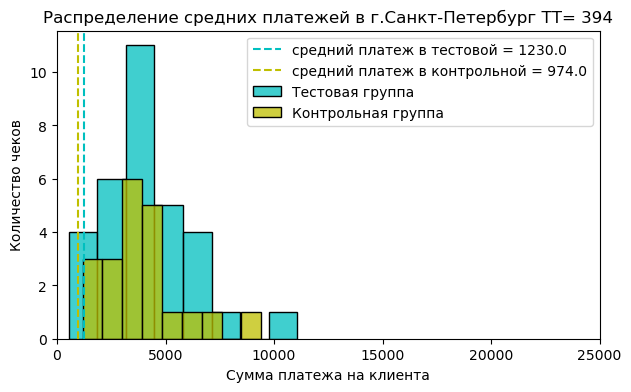

ВЫВОДЫ по г.Санкт-Петербург в ТТ 394 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



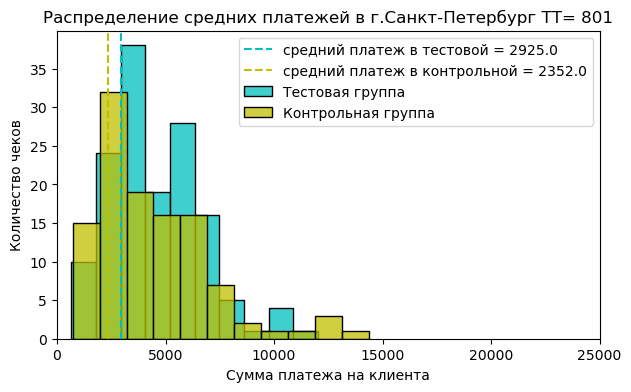

ВЫВОДЫ по г.Санкт-Петербург в ТТ 801 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  572.8592033542977

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1158700209643605

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1751781970649896



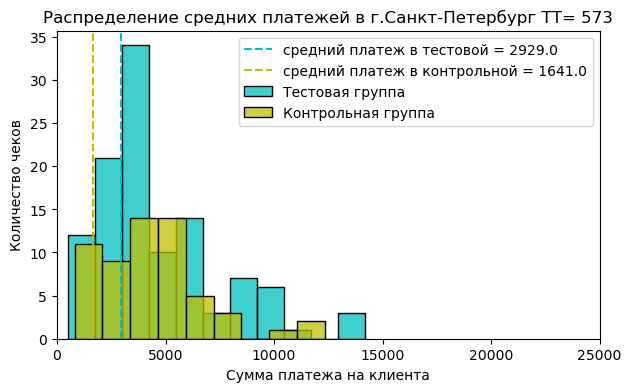

ВЫВОДЫ по г.Санкт-Петербург в ТТ 573 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1287.832697740113

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.2583686440677966

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.3805084745762712



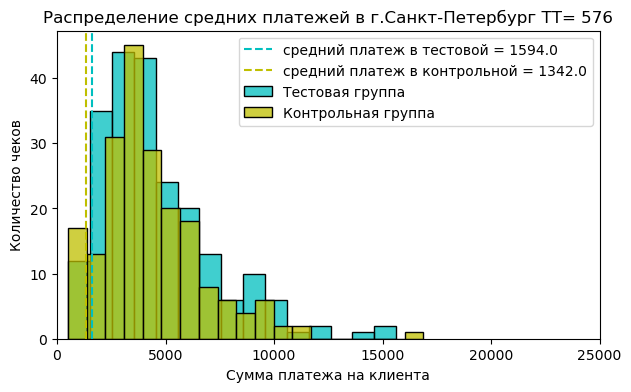

ВЫВОДЫ по г.Санкт-Петербург в ТТ 576 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.07953903022396175



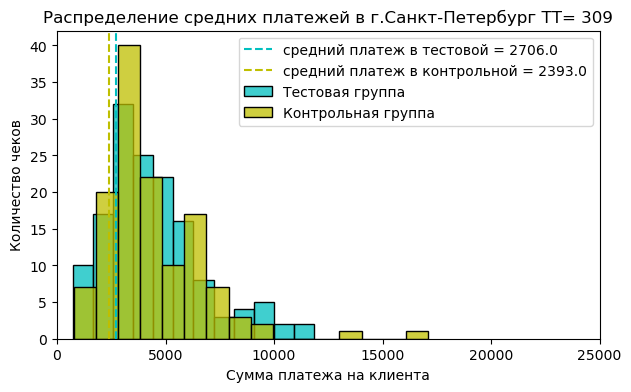

ВЫВОДЫ по г.Санкт-Петербург в ТТ 309 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



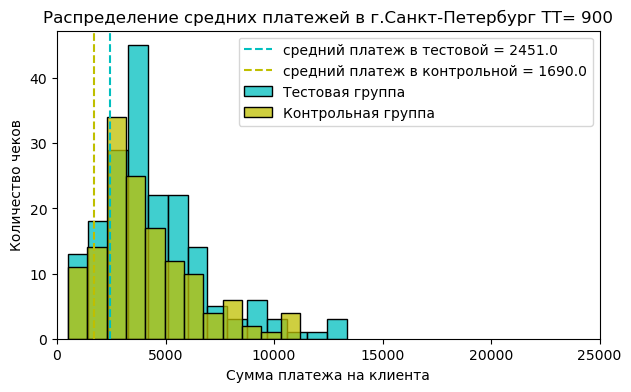

ВЫВОДЫ по г.Санкт-Петербург в ТТ 900 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  761.1992559198145

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.14168162121941613

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1999737383463912



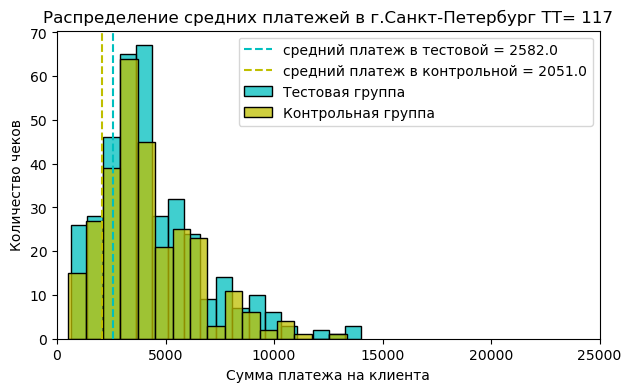

ВЫВОДЫ по г.Санкт-Петербург в ТТ 117 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  531.6059475298125

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.10467325383304943

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.16266575809199313



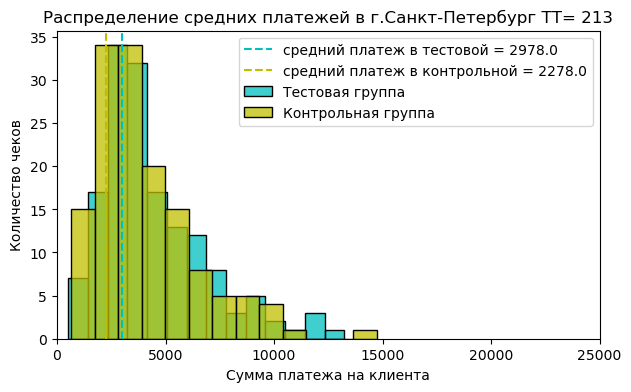

ВЫВОДЫ по г.Санкт-Петербург в ТТ 213 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  700.0175456389452

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.11124070317782286

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.18678160919540232



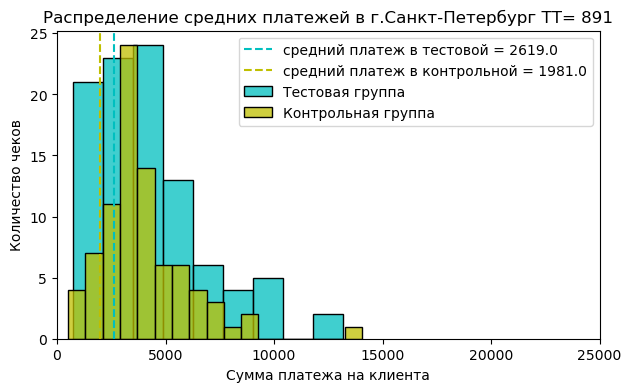

ВЫВОДЫ по г.Санкт-Петербург в ТТ 891 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  638.2910028998606

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.11934621323390954

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.21669867811546728



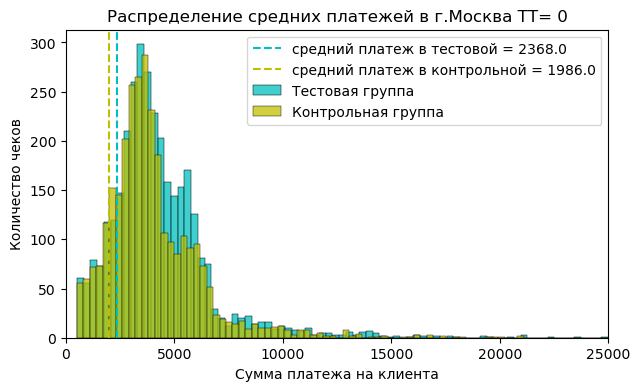

ВЫВОДЫ по г.Москва в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  381.7784892750842

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.05557800593933432

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.06487262198224242



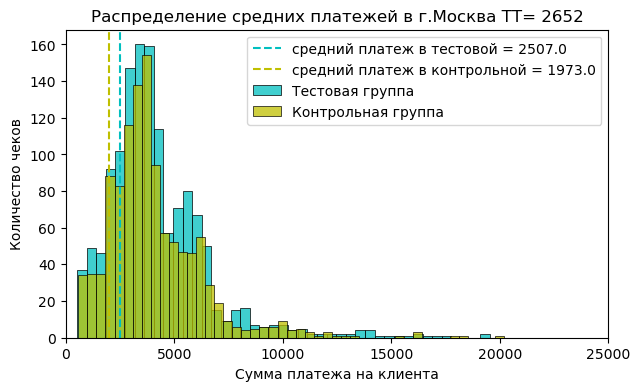

ВЫВОДЫ по г.Москва в ТТ 2652 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  533.7691266583877

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1083107326698855

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1356589276797333



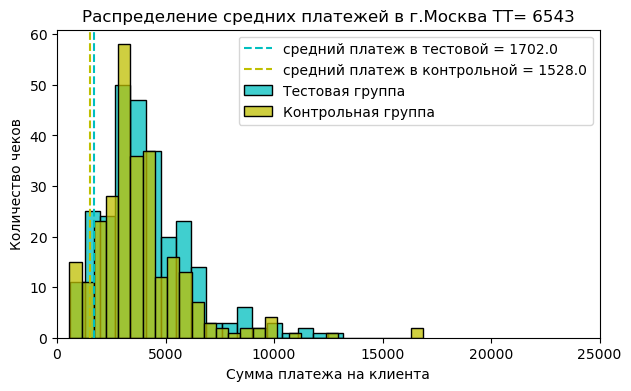

ВЫВОДЫ по г.Москва в ТТ 6543 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



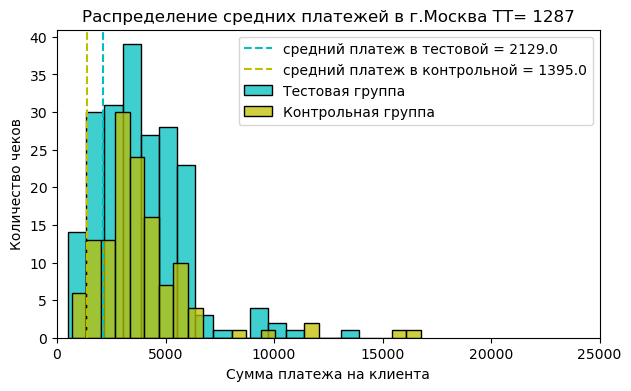

ВЫВОДЫ по г.Москва в ТТ 1287 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  733.901294571883

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.19000681353622534

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.20764630176394888



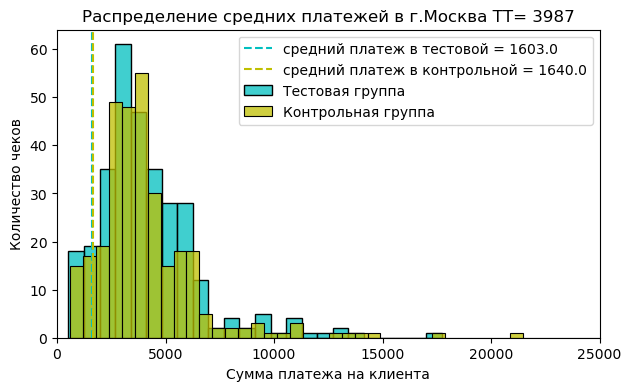

ВЫВОДЫ по г.Москва в ТТ 3987 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



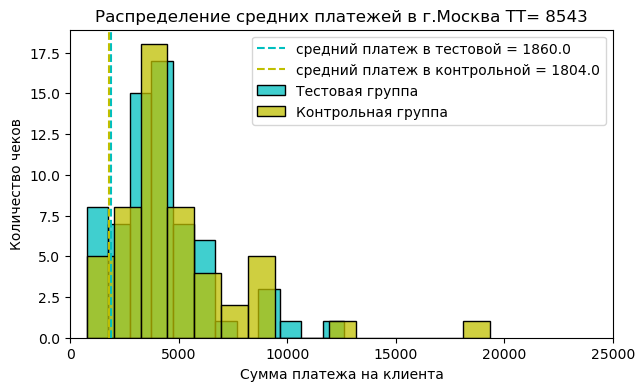

ВЫВОДЫ по г.Москва в ТТ 8543 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



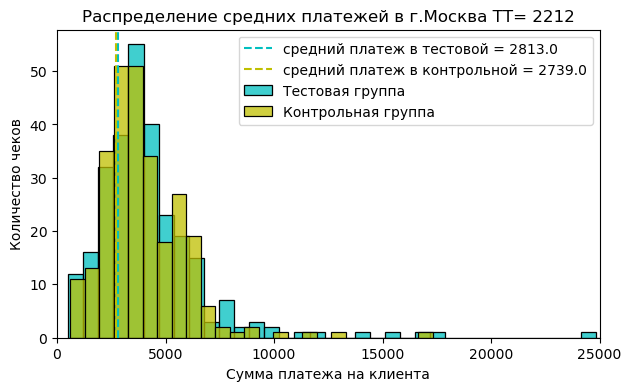

ВЫВОДЫ по г.Москва в ТТ 2212 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



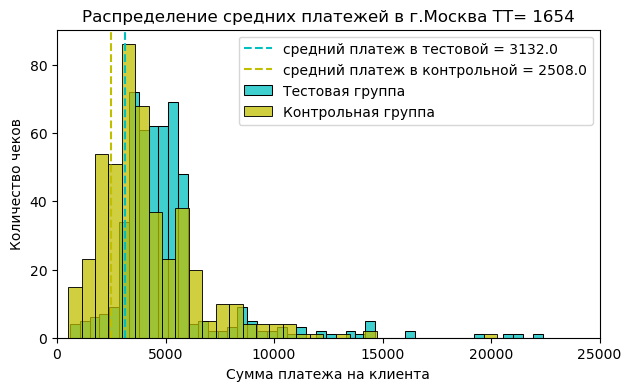

ВЫВОДЫ по г.Москва в ТТ 1654 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  624.4151754208888

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



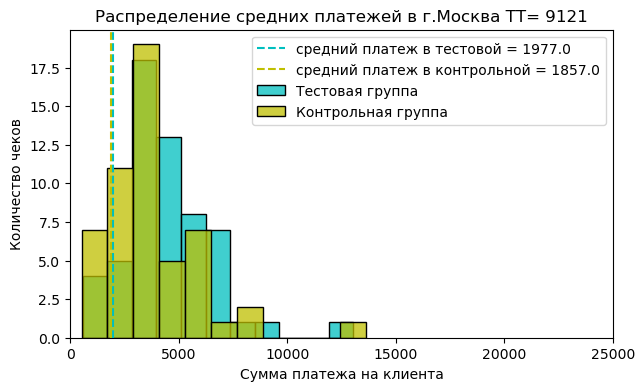

ВЫВОДЫ по г.Москва в ТТ 9121 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



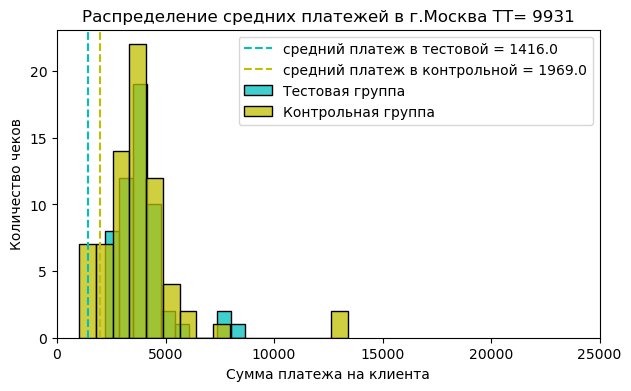

ВЫВОДЫ по г.Москва в ТТ 9931 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -552.909116931444

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.15877105099947525

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.19832069080673626



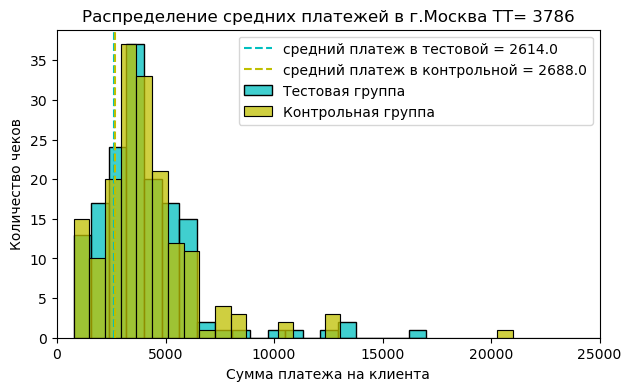

ВЫВОДЫ по г.Москва в ТТ 3786 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



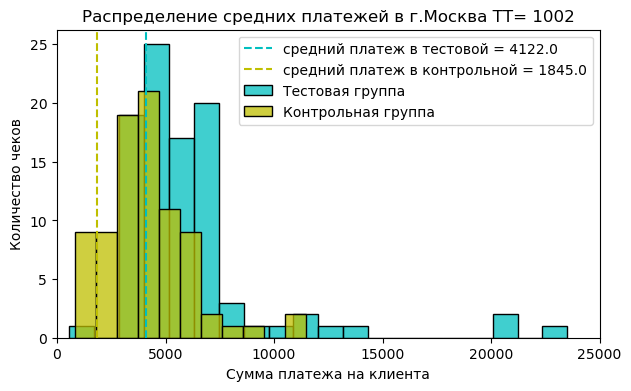

ВЫВОДЫ по г.Москва в ТТ 1002 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  2276.966389145853

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.23435090965155725

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.32947887758248534



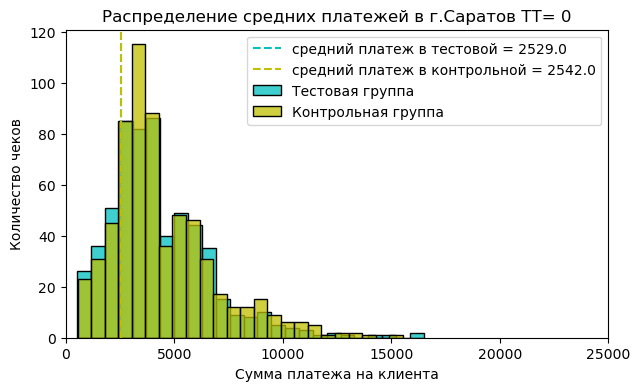

ВЫВОДЫ по г.Саратов в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



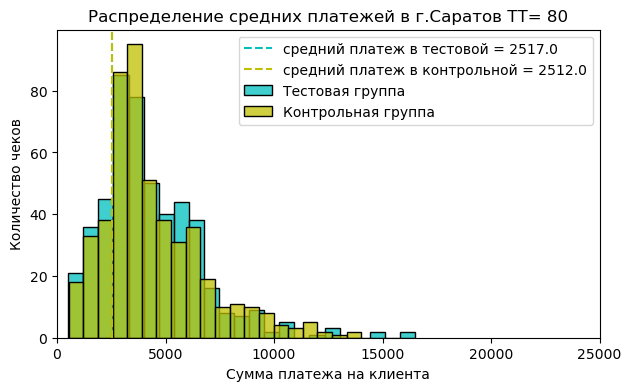

ВЫВОДЫ по г.Саратов в ТТ 80 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



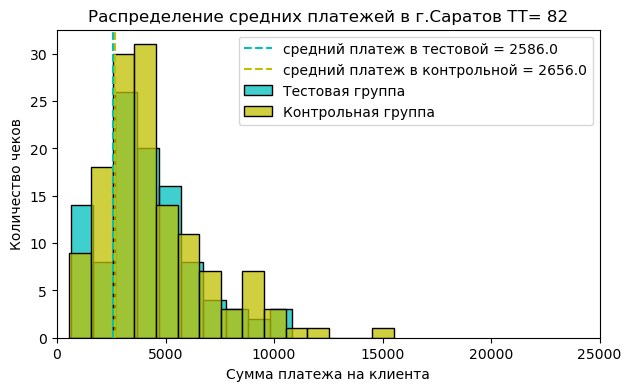

ВЫВОДЫ по г.Саратов в ТТ 82 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



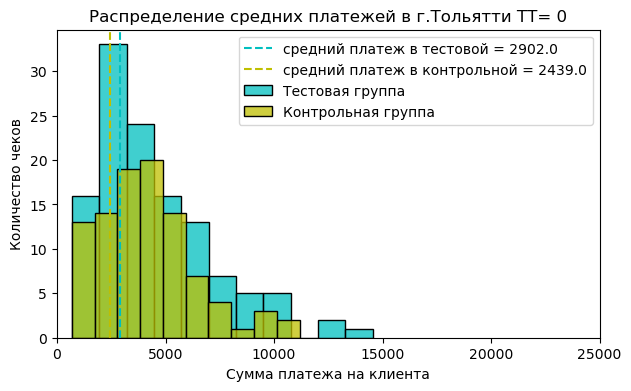

ВЫВОДЫ по г.Тольятти в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



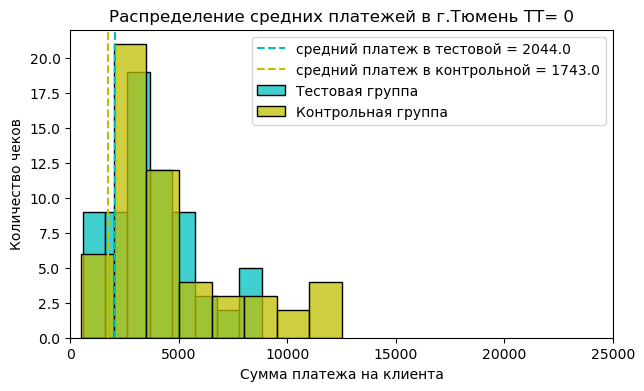

ВЫВОДЫ по г.Тюмень в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1463645943097998

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



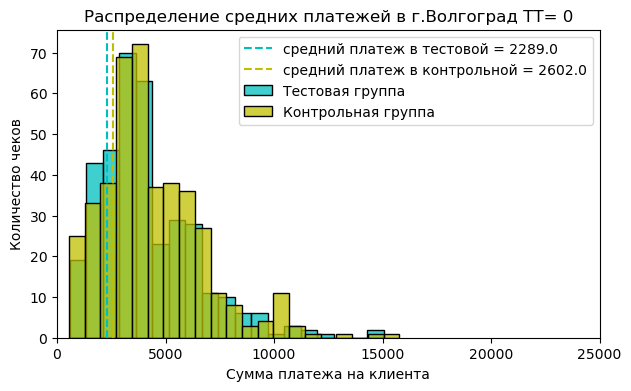

ВЫВОДЫ по г.Волгоград в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -312.89040013337035

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



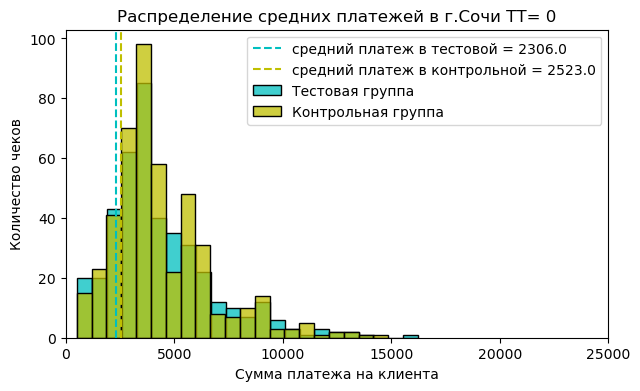

ВЫВОДЫ по г.Сочи в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.04931605920420967

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



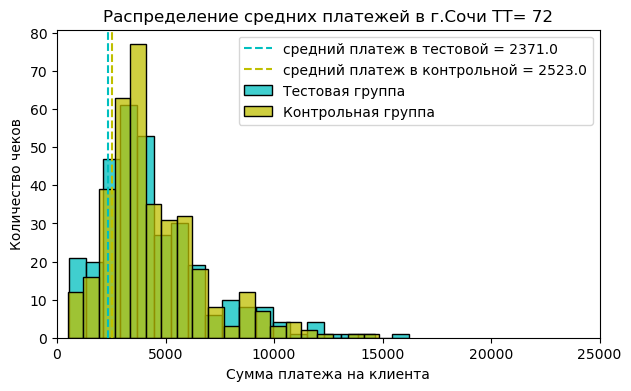

ВЫВОДЫ по г.Сочи в ТТ 72 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



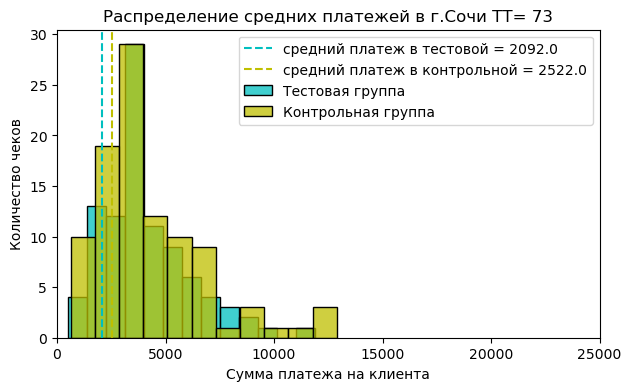

ВЫВОДЫ по г.Сочи в ТТ 73 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



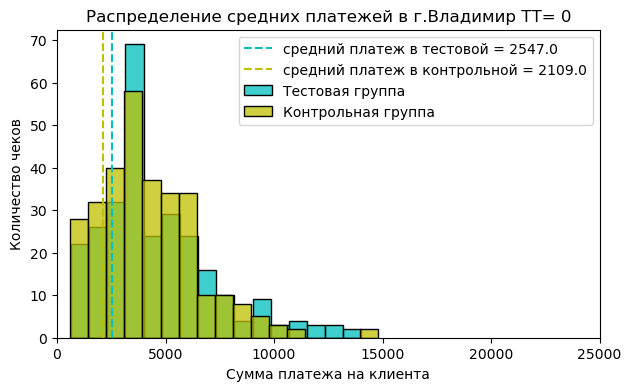

ВЫВОДЫ по г.Владимир в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  438.6098419243094

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.09743692482680177



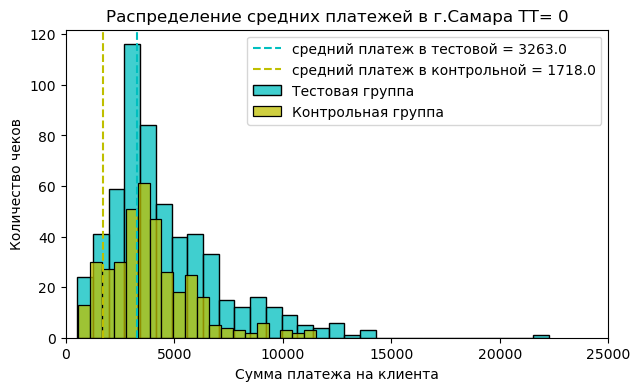

ВЫВОДЫ по г.Самара в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1544.3720191247648

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.2772412939282998

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.43640897755610975



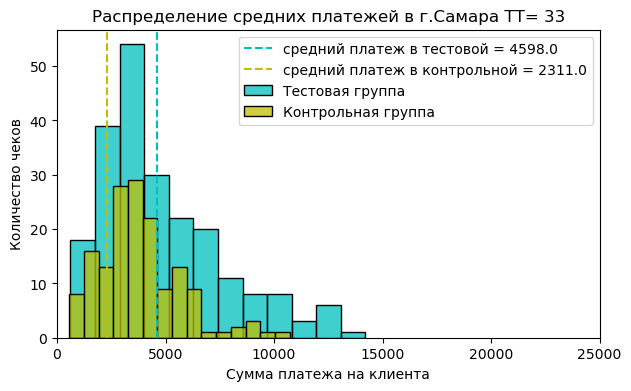

ВЫВОДЫ по г.Самара в ТТ 33 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  2286.832230686982

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.3436246992782679

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.6454156642608929



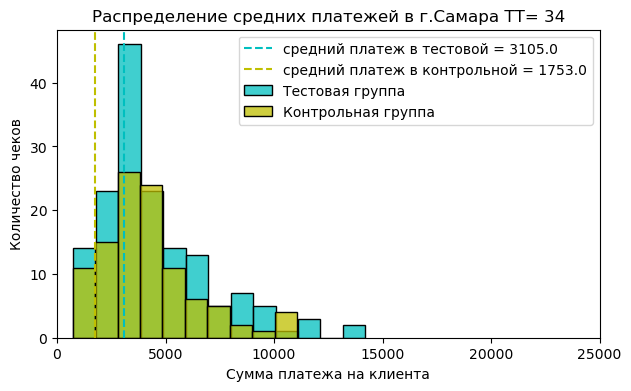

ВЫВОДЫ по г.Самара в ТТ 34 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1351.8979710144927

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.27831357048748356

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.36815107597716296



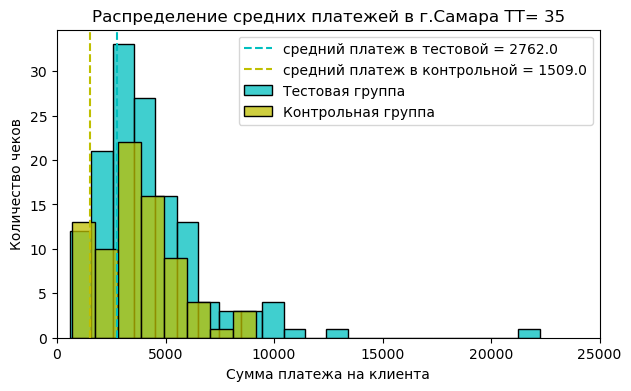

ВЫВОДЫ по г.Самара в ТТ 35 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1253.3892475190287

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.24747085461027074

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.3950765969746604



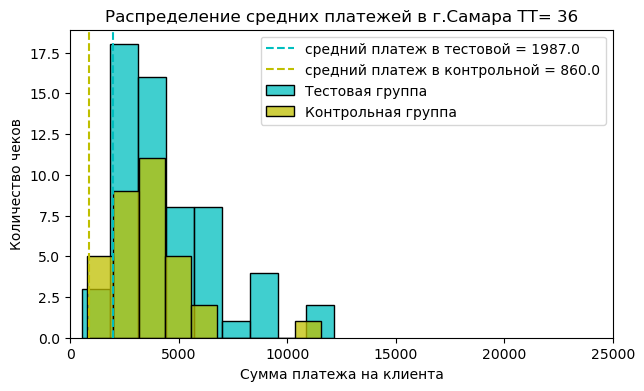

ВЫВОДЫ по г.Самара в ТТ 36 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1126.909804558497

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.22397271398408314

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.2811975529207948



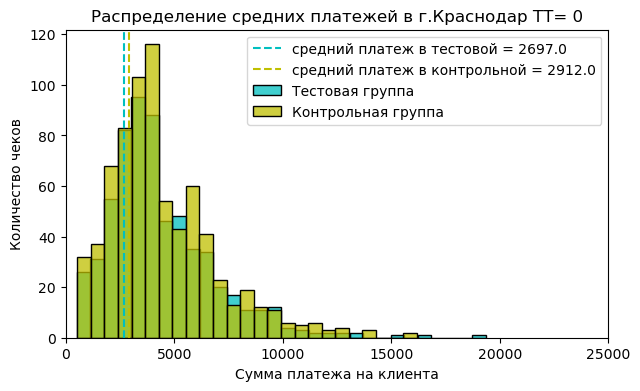

ВЫВОДЫ по г.Краснодар в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



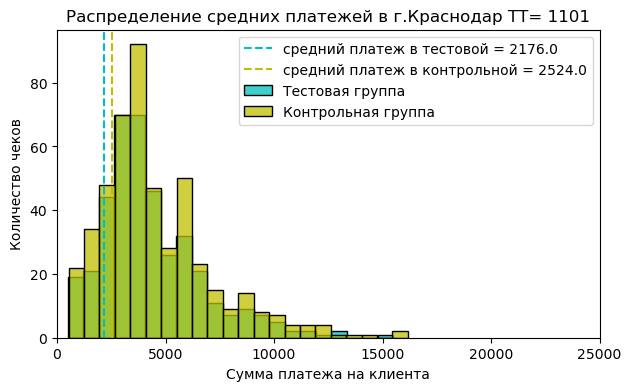

ВЫВОДЫ по г.Краснодар в ТТ 1101 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -347.5750045810032

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.05250342659034102

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.091807700483021



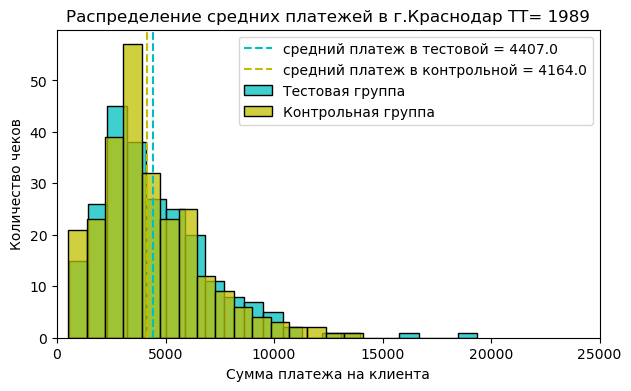

ВЫВОДЫ по г.Краснодар в ТТ 1989 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



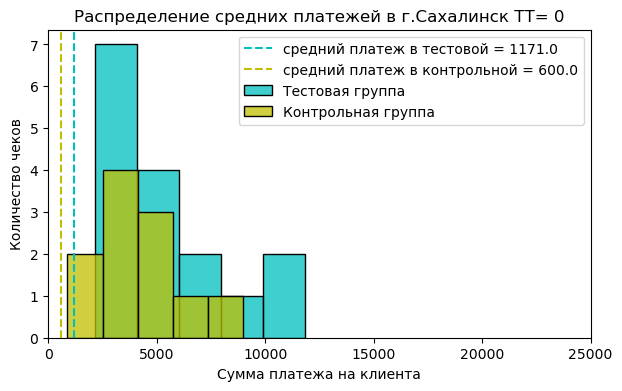

ВЫВОДЫ по г.Сахалинск в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



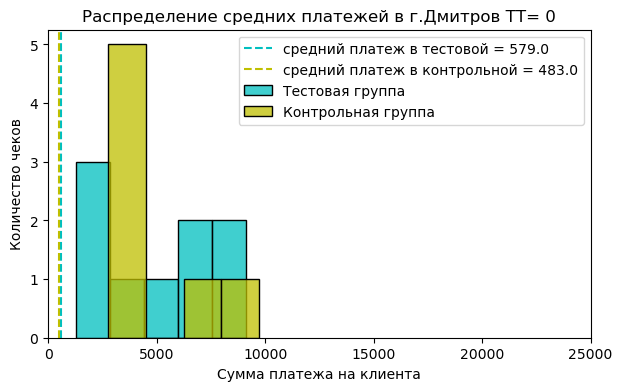

ВЫВОДЫ по г.Дмитров в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



In [105]:
# Город в целом и по каждая торговая точка этого города отдельно

for i in df_fin['city'].unique():
    
    df_city = df_fin[df_fin['city']==i]
    histplot(df_city, i, 0)
    
    if df_city['id_trading_point'].nunique() >1: # не еще раз график, если ТТ одна в городе
        
        for j in df_city['id_trading_point'].unique():
            df_point = df_city[df_city['id_trading_point']==j]
            histplot(df_point, i, j)

7. ***Отчет по АБ Тесту***
    

    Создаем пустой датафрейм. Запускаем цикл по всем городам и торговым точкам.
    

In [108]:
columns_res={'city':[], \
             'id_trading_point':[],\
             'clients_test':[],\
             'clients_control':[],\
             'count_all':[],\
             'payments_test':[],\
             'payments_control':[],\
             'diff':[],\
             'sigma_test':[],\
             'sigma_control':[],\
             'ttest':[],\
             'pvalue_ttest':[],\
             'pvalue_ttest_conv':[]}
df_result=pd.DataFrame(columns_res)

for i in df_fin['id_trading_point'].unique():
    
    dff = df_fin[df_fin['id_trading_point']== i] 
    
    cnt_test = len(dff[dff['nflag_test']==1])
    cnt_control = len(dff[dff['nflag_test']==0])
    cnt_all= cnt_test + cnt_control
    avg_test = dff[dff['nflag_test']==1]['amt_payment'].mean()
    avg_control = dff[dff['nflag_test']==0]['amt_payment'].mean()
    diff = avg_test - avg_control
    s_test = dff[dff['nflag_test']==1]['amt_payment'].std()
    s_control = dff[dff['nflag_test']==0]['amt_payment'].std()
    s_amt, p_amt = ttest_ind(dff[dff['nflag_test']==1]['amt_payment'],dff[dff['nflag_test']==0]['amt_payment'])
    s_conv, p_conv = ttest_ind(dff[dff['nflag_test']==1]['flag_payment'],dff[dff['nflag_test']==0]['flag_payment'])
    
    metrics = {'city':dff['city'].unique(), \
             'id_trading_point':[i],\
             'clients_test':[cnt_test],\
             'clients_control':[cnt_control],\
             'count_all':[cnt_all],\
             'payments_test':[avg_test],\
             'payments_control':[avg_control],\
             'diff':[diff],\
             'sigma_test':[s_test],\
             'sigma_control':[s_control],\
             'ttest':[s_amt],\
             'pvalue_ttest':[p_amt],\
             'pvalue_ttest_conv':[p_conv]}
    
    list_by_point = pd.DataFrame(metrics)
    df_result=pd.concat([df_result,list_by_point],ignore_index=True).sort_values(by=['city','id_trading_point','count_all'])
df_result.head(5)

,city,id_trading_point,clients_test,clients_control,count_all,payments_test,payments_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,pvalue_ttest_conv
0,Владимир,11.0,509.0,608.0,1117.0,2547.220039,2108.610197,438.609842,3023.702164,2663.038392,2.576955,0.010095,0.084816
1,Волгоград,66.0,657.0,703.0,1360.0,2288.870624,2601.761024,-312.890400,2682.567610,2830.193773,-2.089272,0.036869,0.104989
2,Дмитров,2.0,78.0,71.0,149.0,579.333333,483.450704,95.882629,1860.762430,1654.923182,0.331052,0.741076,0.742942
3,Казань,439.0,355.0,351.0,706.0,2481.960563,2400.635328,81.325236,4040.441007,3722.117072,0.278067,0.781042,0.662159
4,Казань,477.0,382.0,386.0,768.0,2259.623037,2496.987047,-237.364010,3482.846094,3881.994719,-0.891593,0.372891,0.756852


In [109]:
df_result['percent_count'] = df_result['count_all']/df_result['count_all'].sum()
df_result['nflag_diff'] = np.where((df_result['diff'] >0) & (df_result['pvalue_ttest']<0.05), 'Positive',\
                                np.where((df_result['diff'] <0) & (df_result['pvalue_ttest']<0.05), 'Negative', 'No_diff'))
df_result.head(5)

,city,id_trading_point,clients_test,clients_control,count_all,payments_test,payments_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,pvalue_ttest_conv,percent_count,nflag_diff
0,Владимир,11.0,509.0,608.0,1117.0,2547.220039,2108.610197,438.609842,3023.702164,2663.038392,2.576955,0.010095,0.084816,0.024648,Positive
1,Волгоград,66.0,657.0,703.0,1360.0,2288.870624,2601.761024,-312.890400,2682.567610,2830.193773,-2.089272,0.036869,0.104989,0.030010,Negative
2,Дмитров,2.0,78.0,71.0,149.0,579.333333,483.450704,95.882629,1860.762430,1654.923182,0.331052,0.741076,0.742942,0.003288,No_diff
3,Казань,439.0,355.0,351.0,706.0,2481.960563,2400.635328,81.325236,4040.441007,3722.117072,0.278067,0.781042,0.662159,0.015579,No_diff
4,Казань,477.0,382.0,386.0,768.0,2259.623037,2496.987047,-237.364010,3482.846094,3881.994719,-0.891593,0.372891,0.756852,0.016947,No_diff


    Выгружаем полученные результаты в Excel. 

In [112]:
writer = pd.ExcelWriter('Калькулятор АВ_тест Горбачева О.С..xlsx')

df_result[df_result['nflag_diff'] == 'Positive'].to_excel(writer, sheet_name='Positive')
df_result[df_result['nflag_diff'] == 'Negative'].to_excel(writer, sheet_name='Negative')
df_result[df_result['nflag_diff'] == 'No_diff'].to_excel(writer, sheet_name='No_diff')
df_result.to_excel(writer, sheet_name='Total_results')

writer.close()